In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Le résulat de cette cellule est un dataframe avec la liste des tags par carton avec le nombre de tags dans chaque carton

Les cartons sont dans la cellule refListId_actual. Dans la colonne Q refList_actual on a le nombre de tags par carton

In [2]:
pathfile='data_anonymous'

# reflist: list of epc in each box
reflist=pd.DataFrame()
# 
files=os.listdir(pathfile) # retourne une liste des fichiers dans le répertoire pathfile
for file in files:
    #print(file)
    if file.startswith('reflist_'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
        temp['refListId']=file.split('.')[0]
        reflist = pd.concat([reflist, temp])
reflist=reflist.rename(columns={'refListId':'refListId_actual'})
reflist['refListId_actual']=reflist['refListId_actual'].apply(lambda x:int(x[8:]))
Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
reflist.head(130)

,Epc,refListId_actual,Q refListId_actual
0,epc_90,0,16
1,epc_91,0,16
2,epc_92,0,16
3,epc_93,0,16
4,epc_94,0,16
...,...,...,...
125,epc_111,6,24
126,epc_112,6,24
127,epc_113,6,24
128,epc_114,6,24


Tags: logtime, epc, rssi, ant, loc

In [3]:
# pathfile=r'data_anonymous'
# 
# df : rfid readings
tags=pd.DataFrame()
# 
files=os.listdir(pathfile)
for file in files:
    #print(file)
    if file.startswith('ano_APTags'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
        tags=pd.concat([tags,temp])
tags['LogTime']=pd.to_datetime (tags['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
tags['TimeStamp']=tags['TimeStamp'].astype(float)
tags['Rssi']=tags['Rssi'].astype(float)
tags=tags.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
tags=tags[['LogTime', 'Epc', 'Rssi', 'Ant']]
# antennas 1 and 2 are facing the box when photocell in/out 
Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
tags=pd.merge(tags,Ant_loc,on=['Ant'])
tags=tags.sort_values('LogTime').reset_index(drop=True)
tags.head()

,LogTime,Epc,Rssi,Ant,loc
0,2019-11-07 15:32:10,epc_100,-69.0,3,out
1,2019-11-07 15:32:10,epc_97,-69.0,3,out
2,2019-11-07 15:32:10,epc_97,-65.0,3,out
3,2019-11-07 15:32:10,epc_99,-70.0,3,out
4,2019-11-07 15:32:10,epc_100,-66.0,3,out


Fenêtre de lecture

rflistId est l'id de la boxe

In [4]:
# timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
file='ano_supply-process.2019-11-07-CUT.csv'
timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
timing['file']=file
timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Start']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Stop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
timing['timestampStart']=timing['timestampStart'].astype(float)
timing['timestampStop']=timing['timestampStop'].astype(float)
timing=timing.sort_values('date')
timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
timing=timing[['refListId', 'Start', 'Stop']]
timing[:12]

,refListId,Start,Stop
0,0,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197
1,1,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463
2,2,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447
3,3,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591
4,4,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528
5,5,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278
6,6,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685
7,7,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611
8,8,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158
9,9,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051


Fenêtre de décision: full window

In [5]:
# Start_up starts upstream Start, half way in between the previous stop and the actual start
timing[['Stop_last']]=timing[['Stop']].shift(1)
timing[['refListId_last']]=timing[['refListId']].shift(1)
timing['Startup']=timing['Start'] - (timing['Start'] - timing['Stop_last'])/2
# timing start: 10sec before timing
timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
timing.loc[0,'Startup']=timing.loc[0,'Start']-datetime.timedelta(seconds=10)
timing.loc[0,'Stop_last']=timing.loc[0,'Startup']-datetime.timedelta(seconds=10)
timing['refListId_last']=timing['refListId_last'].astype(int)
# 
timing['Stopdown']= timing['Startup'].shift(-1)
timing.loc[len(timing)-1,'Stopdown']=timing.loc[len(timing)-1,'Stop']+datetime.timedelta(seconds=10)
timing=timing[['refListId', 'refListId_last','Startup', 'Start','Stop','Stopdown']]
timing.head(30)

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000
2,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500
3,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000
4,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000
5,5,4,2019-11-07 18:54:27.475000,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278,2019-11-07 18:54:33.115500
6,6,5,2019-11-07 18:54:33.115500,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685,2019-11-07 18:54:38.757000
7,7,6,2019-11-07 18:54:38.757000,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611,2019-11-07 18:54:44.497000
8,8,7,2019-11-07 18:54:44.497000,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158,2019-11-07 18:54:50.140000
9,9,8,2019-11-07 18:54:50.140000,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051,2019-11-07 18:54:55.894500


In [6]:
# box 0 always starts
timing[timing['refListId']==0].head(20)

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
10,0,9,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765000
20,0,9,2019-11-07 18:55:53.460500,2019-11-07 18:55:55.497,2019-11-07 18:55:57.377,2019-11-07 18:55:59.567500
30,0,9,2019-11-07 18:56:51.317000,2019-11-07 18:56:53.344,2019-11-07 18:56:55.215,2019-11-07 18:56:57.241500
40,0,9,2019-11-07 18:58:02.390500,2019-11-07 18:58:04.351,2019-11-07 18:58:06.212,2019-11-07 18:58:11.428000
50,0,9,2019-11-07 18:59:12.578000,2019-11-07 18:59:15.434,2019-11-07 18:59:17.301,2019-11-07 18:59:19.361000
60,0,9,2019-11-07 19:00:11.355000,2019-11-07 19:00:13.213,2019-11-07 19:00:15.107,2019-11-07 19:00:17.173500
70,0,9,2019-11-07 19:01:08.444500,2019-11-07 19:01:10.422,2019-11-07 19:01:12.311,2019-11-07 19:01:14.344500
80,0,9,2019-11-07 19:02:06.147000,2019-11-07 19:02:08.207,2019-11-07 19:02:10.091,2019-11-07 19:02:12.092500
90,0,9,2019-11-07 19:03:30.097500,2019-11-07 19:03:37.718,2019-11-07 19:03:39.566,2019-11-07 19:03:41.560000


In [7]:
# t0_run = a new run starts when box 0 shows up
# t0_run: c'est l'instant à partir duquel commence un run, chaque run commence avec la boxe 0
# run : id du run
t0_run=timing[timing['refListId']==0] [['Startup']]
t0_run=t0_run.rename(columns={'Startup':'t0_run'})
t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
t0_run=t0_run.sort_values('t0_run')
# 
# each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
timing=pd.merge_asof(timing,t0_run,left_on='Startup',right_on='t0_run', direction='backward')
timing=timing.sort_values('Stop')
timing=timing[['run', 'refListId', 'refListId_last', 'Startup','Start','Stop','Stopdown','t0_run']]
timing.head(20)
#timing['run'].value_counts()

,run,refListId,refListId_last,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000,2019-11-07 18:53:42.370000
1,1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000,2019-11-07 18:53:42.370000
2,1,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500,2019-11-07 18:53:42.370000
3,1,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000,2019-11-07 18:53:42.370000
4,1,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000,2019-11-07 18:53:42.370000
5,1,5,4,2019-11-07 18:54:27.475000,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278,2019-11-07 18:54:33.115500,2019-11-07 18:53:42.370000
6,1,6,5,2019-11-07 18:54:33.115500,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685,2019-11-07 18:54:38.757000,2019-11-07 18:53:42.370000
7,1,7,6,2019-11-07 18:54:38.757000,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611,2019-11-07 18:54:44.497000,2019-11-07 18:53:42.370000
8,1,8,7,2019-11-07 18:54:44.497000,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158,2019-11-07 18:54:50.140000,2019-11-07 18:53:42.370000
9,1,9,8,2019-11-07 18:54:50.140000,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051,2019-11-07 18:54:55.894500,2019-11-07 18:53:42.370000


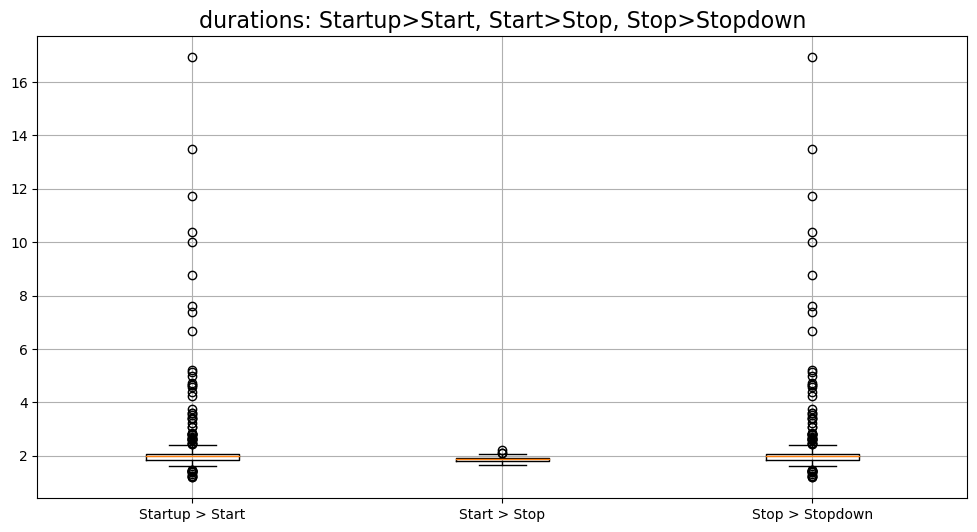

In [8]:
plt.figure(figsize=(12,6))
up=(timing['Start']-timing['Startup']).apply(lambda x:x.total_seconds())
mid=(timing['Stop']-timing['Start']).apply(lambda x:x.total_seconds())
down=(timing['Stopdown']-timing['Stop']).apply(lambda x:x.total_seconds())
plt.boxplot([up,mid,down],labels=['Startup > Start','Start > Stop','Stop > Stopdown'])
plt.grid()
plt.title('durations: Startup>Start, Start>Stop, Stop>Stopdown',size=16)
plt.show()

In [9]:
#  full window (Startup > Stopdown) is sliced in smaller slices
# Startup > Start: 11 slices named up_0, up_1, ..., up_10
# Start > Stop: 11 slices named mid_0, mid_1, ... mid_10
# Stop > Stopdown: 11 slices names down_0, down_1, ... down_10
slices=pd.DataFrame()
for i, row in timing.iterrows(): 
    ciuchStartup=row['Startup']
    ciuchStart=row['Start']
    ciuchStop=row['Stop']
    ciuchStopdown=row['Stopdown']
    steps=4
#     
    up=pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    up.index=['up_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, up])    
  
    mid=pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    mid.index=['mid_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, mid])
#     
    down=pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    down.index=['down_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, down])

slices=slices.reset_index(drop=False).rename(columns={'index':'slice_id'})
# 
timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='Startup',direction='backward')
timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                             'Startup', 'Start', 'Stop', 'Stopdown','t0_run']]
timing_slices.head()

,run,refListId,refListId_last,slice_id,slice,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
1,1,0,0,up_1,2019-11-07 18:53:45.703333333,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
2,1,0,0,up_2,2019-11-07 18:53:49.036666666,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
3,1,0,0,up_3,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
4,1,0,0,mid_0,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370


Fusion des dataframes tags et timing_slices: df_timing_slices

In [10]:
# merge between tags and timing
# merge_asof needs sorted df > df_ref
df = tags
df=df[(tags['LogTime']>=timing['Startup'].min()) & (df['LogTime']<=timing['Stopdown'].max())]
df=df.sort_values('LogTime')
df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
df_timing_slices=df_timing_slices.dropna()
df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
df_timing_slices['window_run_id']  = df_timing_slices['refListId'].astype(str) +'_'+ df_timing_slices['run'].astype(str)
df_timing_slices=df_timing_slices[['run', 'window_run_id', 'Epc','refListId', 'refListId_last', 'Startup','slice_id','slice','LogTime','Start','Stop', 'Stopdown', 'Rssi', 'loc','t0_run']]
df_timing_slices

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run
0,1,0_1,epc_131,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:43,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-62.0,out,2019-11-07 18:53:42.370
1,1,0_1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-67.0,in,2019-11-07 18:53:42.370
2,1,0_1,epc_131,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-69.0,in,2019-11-07 18:53:42.370
3,1,0_1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-67.0,out,2019-11-07 18:53:42.370
4,1,0_1,epc_175,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-65.0,out,2019-11-07 18:53:42.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356063,40,1_40,epc_162,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-67.0,out,2019-11-07 19:34:37.679
356064,40,1_40,epc_187,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-65.0,out,2019-11-07 19:34:37.679
356065,40,1_40,epc_87,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-69.0,out,2019-11-07 19:34:37.679
356066,40,1_40,epc_188,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-59.0,out,2019-11-07 19:34:37.679


In [11]:
runs_out=df_timing_slices .groupby('run')['refListId'].nunique().rename('Q refListId').reset_index(drop=False)
runs_out[runs_out['Q refListId']!=10]

,run,Q refListId
15,16,9
22,23,9
31,32,9
39,40,2


In [12]:
current_last_windows=timing_slices.drop_duplicates(['run','refListId','refListId_last'])
current_last_windows=current_last_windows[['run','refListId','refListId_last','Stop']].reset_index(drop=True)
current_last_windows[:1]

,run,refListId,refListId_last,Stop
0,1,0,0,2019-11-07 18:53:54.197


In [13]:
# runs 16 23 32 40 have missing boxes: discarded
# also run 1 is the start, no previous box: discarded
# run 18: box 0 run at the end
# 
timing=timing[~timing['run'].isin([1,18,16,23,32,40])]
timing_slices=timing_slices[~timing_slices['run'].isin([1,18,16,23,32,40])]
df_timing_slices=df_timing_slices[~df_timing_slices['run'].isin([1,18,16,23,32,40])]

df_timing_slices=df_timing_slices.sort_values(['LogTime','Epc'])
# 

In [14]:
len(timing),len(timing_slices), len(df_timing_slices)

(340, 4080, 307965)

In [15]:
df_timing_slices[:1]

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run
8970,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-68.0,in,2019-11-07 18:54:55.894500


In [16]:
# df_timing_slices['dt']=
df_timing_slices['dt']=(df_timing_slices['LogTime']-df_timing_slices['t0_run']).apply(lambda x:x.total_seconds())

In [17]:
df_timing_slices[:1]

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run,dt
8970,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-68.0,in,2019-11-07 18:54:55.894500,0.1055


In [18]:
rssi_threshold=-110
df_timing_slices_threshold=df_timing_slices[df_timing_slices['Rssi']>rssi_threshold]

In [19]:
# readrate
# readrate
round(100*df_timing_slices_threshold.reset_index(drop=False).groupby(['run','loc'])['Epc'].nunique().groupby('loc').mean()\
    /reflist['Epc'].nunique(),2)

loc
in     100.00
out     99.29
Name: Epc, dtype: float64

In [20]:
df_timing_slices

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run,dt
8970,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-68.0,in,2019-11-07 18:54:55.894500,0.1055
8971,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-47.0,out,2019-11-07 18:54:55.894500,0.1055
9003,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-54.0,out,2019-11-07 18:54:55.894500,0.1055
9010,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-50.0,out,2019-11-07 18:54:55.894500,0.1055
9082,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-69.0,in,2019-11-07 18:54:55.894500,0.1055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354254,39,9_39,epc_99,9,8,2019-11-07 19:34:31.683000,down_1,2019-11-07 19:34:36.340333333,2019-11-07 19:34:37,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,-62.0,in,2019-11-07 19:33:38.447500,58.5525
354277,39,9_39,epc_99,9,8,2019-11-07 19:34:31.683000,down_1,2019-11-07 19:34:36.340333333,2019-11-07 19:34:37,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,-51.0,out,2019-11-07 19:33:38.447500,58.5525
354305,39,9_39,epc_99,9,8,2019-11-07 19:34:31.683000,down_1,2019-11-07 19:34:36.340333333,2019-11-07 19:34:37,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,-62.0,in,2019-11-07 19:33:38.447500,58.5525
354353,39,9_39,epc_99,9,8,2019-11-07 19:34:31.683000,down_1,2019-11-07 19:34:36.340333333,2019-11-07 19:34:37,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,-49.0,out,2019-11-07 19:33:38.447500,58.5525


In [21]:
timing_slices

,run,refListId,refListId_last,slice_id,slice,Startup,Start,Stop,Stopdown,t0_run
119,2,0,9,down_3,2019-11-07 18:54:55.894500000,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,2019-11-07 18:54:55.894500
120,2,0,9,up_0,2019-11-07 18:54:55.894500000,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,2019-11-07 18:54:55.894500
121,2,0,9,up_1,2019-11-07 18:54:56.509000000,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,2019-11-07 18:54:55.894500
122,2,0,9,up_2,2019-11-07 18:54:57.123500000,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,2019-11-07 18:54:55.894500
123,2,0,9,up_3,2019-11-07 18:54:57.738000000,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,2019-11-07 18:54:55.894500
...,...,...,...,...,...,...,...,...,...,...
4638,39,9,8,mid_2,2019-11-07 19:34:35.012666666,2019-11-07 19:34:31.683000,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,2019-11-07 19:33:38.447500
4639,39,9,8,mid_3,2019-11-07 19:34:35.671000000,2019-11-07 19:34:31.683000,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,2019-11-07 19:33:38.447500
4640,39,9,8,down_0,2019-11-07 19:34:35.671000000,2019-11-07 19:34:31.683000,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,2019-11-07 19:33:38.447500
4641,39,9,8,down_1,2019-11-07 19:34:36.340333333,2019-11-07 19:34:31.683000,2019-11-07 19:34:33.696,2019-11-07 19:34:35.671,2019-11-07 19:34:37.679,2019-11-07 19:33:38.447500


Implémentation de la méthode analytique

In [22]:
ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max()
ana

Epc     window_run_id  slice_id  loc
epc_0   0_10           down_0    out   -67.0
                       down_2    out   -63.0
                       up_2      out   -64.0
        0_19           down_0    out   -69.0
                       mid_0     out   -68.0
                                        ... 
epc_99  9_9            down_1    out   -48.0
                       down_2    in    -61.0
                                 out   -48.0
                       mid_0     out   -71.0
                       mid_2     out   -63.0
Name: Rssi, Length: 97948, dtype: float64

In [23]:
ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)
ana

loc,Epc,window_run_id,slice_id,in,out
0,epc_0,0_10,down_0,-110.0,-67.0
1,epc_0,0_10,down_2,-110.0,-63.0
2,epc_0,0_10,up_2,-110.0,-64.0
3,epc_0,0_19,down_0,-110.0,-69.0
4,epc_0,0_19,mid_0,-110.0,-68.0
...,...,...,...,...,...
82437,epc_99,9_9,down_0,-61.0,-47.0
82438,epc_99,9_9,down_1,-61.0,-48.0
82439,epc_99,9_9,down_2,-61.0,-48.0
82440,epc_99,9_9,mid_0,-110.0,-71.0


In [24]:
order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
order['order']=order.index
order

,slice_id,order
0,down_3,0
1,up_0,1
2,up_1,2
3,up_2,3
4,up_3,4
5,mid_0,5
6,mid_1,6
7,mid_2,7
8,mid_3,8
9,down_0,9


In [25]:
ana=pd.merge(ana, order, on='slice_id', how='left')
ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
ana

,Epc,window_run_id,slice_id,in,out,order
0,epc_0,0_10,down_0,-110.0,-67.0,9
1,epc_0,0_10,down_2,-110.0,-63.0,11
2,epc_0,0_10,up_2,-110.0,-64.0,3
3,epc_0,0_19,down_0,-110.0,-69.0,9
4,epc_0,0_19,mid_0,-110.0,-68.0,5
...,...,...,...,...,...,...
82437,epc_99,9_9,down_0,-61.0,-47.0,9
82438,epc_99,9_9,down_1,-61.0,-48.0,10
82439,epc_99,9_9,down_2,-61.0,-48.0,11
82440,epc_99,9_9,mid_0,-110.0,-71.0,5


In [26]:
ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
ana_out

,Epc,window_run_id,slice_id,in,out,order
82439,epc_99,9_9,down_2,-61.0,-48.0,11
82434,epc_99,9_8,down_2,-67.0,-44.0,11
82430,epc_99,9_7,down_2,-63.0,-47.0,11
82424,epc_99,9_6,down_2,-61.0,-47.0,11
82421,epc_99,9_5,down_2,-66.0,-50.0,11
...,...,...,...,...,...,...
7,epc_0,0_29,down_0,-110.0,-65.0,9
6,epc_0,0_27,down_0,-110.0,-69.0,9
5,epc_0,0_21,down_1,-110.0,-65.0,10
3,epc_0,0_19,down_0,-110.0,-69.0,9


In [27]:
ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])
ana_in

,Epc,window_run_id,slice_id,in,out,order
171,epc_0,5_10,up_2,-51.0,-110.0,3
175,epc_0,5_11,up_2,-49.0,-69.0,3
180,epc_0,5_12,up_2,-56.0,-63.0,3
186,epc_0,5_13,up_2,-50.0,-110.0,3
189,epc_0,5_14,mid_0,-51.0,-110.0,5
...,...,...,...,...,...,...
82143,epc_99,1_6,up_0,-61.0,-110.0,1
82146,epc_99,1_7,up_1,-63.0,-110.0,2
82149,epc_99,1_8,up_0,-62.0,-110.0,1
82152,epc_99,1_9,up_1,-62.0,-110.0,2


In [28]:
ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
ana

,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2
...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1


In [29]:
ana = pd.merge(ana, reflist, on='Epc', how='left')

In [36]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    ana['runs']= ana['window_run_id'].apply(lambda x:x.split('_')[1]).astype('int64')
    true_counts = ana.groupby(['refListId_actual', 'runs'])['pred_ana_bool'].sum()
    
    

    # Pour afficher 100 lignes au maximum
    pd.set_option('display.max_rows', 100)

    # Maintenant, quand vous imprimez, cela devrait afficher jusqu'à 100 lignes.
    print(true_counts)
   # true_counts.to_excel("counts.xlsx",sheet_name="f")

    return ana
ana=analytical(df_timing_slices, timing_slices)
ana

refListId_actual  runs
0                 2       16
                  3       15
                  4       16
                  5       15
                  6       16
                          ..
9                 35       8
                  36       8
                  37       7
                  38       8
                  39       8
Name: pred_ana_bool, Length: 339, dtype: int64


,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT,refListId_actual,Q refListId_actual,pred_ana_bool,runs
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1,5,40,True,10
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2,5,40,True,11
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1,5,40,True,12
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1,5,40,True,13
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2,5,40,True,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2,0,16,True,7
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1,0,16,True,8
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2,0,16,True,9
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1,0,16,False,14


refListId_actual  runs       
0                 2     True     16
                  3     True     15
                  4     True     16
                  5     True     15
                  6     True     16
                  7     True     14
                  8     True     14
                  9     True     15
                  10    True     15
                  11    True     14
                  12    True     16
                  13    True     14
                        False     2
                  14    True     15
                        False     1
                  15    True     16
                  17    True     15
                  19    True     16
                  20    True     15
                  21    True     15
                  22    True     15
                        False     1
                  24    True     16
                  25    True     16
                  26    True     14
                  27    True     15
                  28    True     1

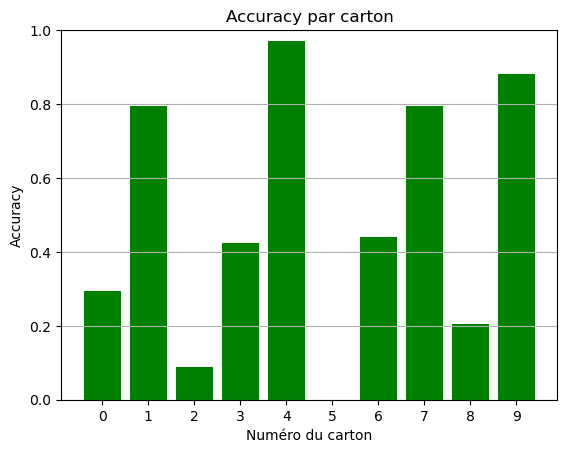

0.9701195219123506


In [38]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    ana['runs']= ana['window_run_id'].apply(lambda x:x.split('_')[1]).astype('int64')
    true_counts = ana.groupby(['refListId_actual', 'runs']).agg(
    unique_Epcs=pd.NamedAgg(column='Epc', aggfunc=lambda x: list(x.unique())),
    sum_pred_ana_bool=pd.NamedAgg(column='pred_ana_bool', aggfunc='sum')
        )
    

    # Pour afficher 100 lignes au maximum
    pd.set_option('display.max_rows', 100)

    # Maintenant, quand vous imprimez, cela devrait afficher jusqu'à 100 lignes.
    #print(true_counts)
    
    #true_counts.to_excel('counts.xlsx', sheet_name = 'True Counts')
    true_false_counts = ana.groupby(['refListId_actual', 'runs'])['pred_ana_bool'].apply(lambda x: x.value_counts())
    print(true_false_counts.head(30))
    
    y_test=df['sum_pred_ana_bool']
    y_pred=df['true_values']

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Supposons que df est votre DataFrame
    accuracies = []
    cartons = range(10)

    # Collecter les valeurs d'accuracy pour chaque carton
    for i in cartons:
        filtered_df = df[df['refListId'] == i]
        y_test = filtered_df['sum_pred_ana_bool']
        y_pred = filtered_df['true_values']
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"Accuracy carton {i}: {acc:.2f}")

    # Créer un diagramme en barres
    plt.bar(cartons, accuracies, color='green')
    plt.title('Accuracy par carton')
    plt.xlabel('Numéro du carton')
    plt.ylabel('Accuracy')
    plt.xticks(cartons)
    plt.ylim([0, 1])  # L'accuracy est toujours entre 0 et 1
    plt.grid(axis='y')  # Ajouter une grille horizontale pour la lisibilité
    plt.show()
    
   
    return ana
ana=analytical(df_timing_slices, timing_slices)
vrai=ana[ana['pred_ana_bool']==True]
accuracy= vrai.shape[0]/ana.shape[0] # (count)
print(accuracy)

In [37]:
# Chemin vers le fichier Excel
file_path = r'counts.xlsx'

# Charger le fichier Excel dans un DataFrame
df = pd.read_excel(file_path)

# Afficher les premières lignes du DataFrame
df.head()

,refListId_actual,runs,unique_Epcs,sum_pred_ana_bool,true_values,refListId
0,0.0,2,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0
1,NaN,3,"['epc_100', 'epc_101', 'epc_102', 'epc_104', '...",15,16,0
2,NaN,4,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0
3,NaN,5,"['epc_100', 'epc_101', 'epc_102', 'epc_104', '...",15,16,0
4,NaN,6,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0


In [39]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    vrai=ana[ana['pred_ana_bool']==True]
    accuracy= vrai.shape[0]/ana.shape[0]
    return accuracy
ana=analytical(df_timing_slices, timing_slices)
ana

0.9701195219123506

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score

In [40]:
def pretraitement():
    pathfile='data_anonymous'

    # reflist: list of epc in each box
    reflist=pd.DataFrame()
    # 
    files=os.listdir(pathfile) # retourne une liste des fichiers dans le répertoire pathfile
    for file in files:
        #print(file)
        if file.startswith('reflist_'):
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
            temp['refListId']=file.split('.')[0]
            reflist = pd.concat([reflist, temp])
    reflist=reflist.rename(columns={'refListId':'refListId_actual'})
    reflist['refListId_actual']=reflist['refListId_actual'].apply(lambda x:int(x[8:]))
    Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
    reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
    
    # 2eme partie
    
    # pathfile=r'data_anonymous'
    # 
    # df : rfid readings
    tags=pd.DataFrame()
    # 
    files=os.listdir(pathfile)
    for file in files:
        #print(file)
        if file.startswith('ano_APTags'):
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
            tags=pd.concat([tags,temp])
    tags['LogTime']=pd.to_datetime (tags['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
    tags['TimeStamp']=tags['TimeStamp'].astype(float)
    tags['Rssi']=tags['Rssi'].astype(float)
    tags=tags.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
    tags=tags[['LogTime', 'Epc', 'Rssi', 'Ant']]
    # antennas 1 and 2 are facing the box when photocell in/out 
    Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
    tags=pd.merge(tags,Ant_loc,on=['Ant'])
    tags=tags.sort_values('LogTime').reset_index(drop=True)
    
    # 3eme partie
    
        # timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
    file='ano_supply-process.2019-11-07-CUT.csv'
    timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
    timing['file']=file
    timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['Start']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['Stop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['timestampStart']=timing['timestampStart'].astype(float)
    timing['timestampStop']=timing['timestampStop'].astype(float)
    timing=timing.sort_values('date')
    timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
    timing=timing[['refListId', 'Start', 'Stop']]
    
    # 4eme partie
    
    # Start_up starts upstream Start, half way in between the previous stop and the actual start
    timing[['Stop_last']]=timing[['Stop']].shift(1)
    timing[['refListId_last']]=timing[['refListId']].shift(1)
    timing['Startup']=timing['Start'] - (timing['Start'] - timing['Stop_last'])/2
    # timing start: 10sec before timing
    timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
    timing.loc[0,'Startup']=timing.loc[0,'Start']-datetime.timedelta(seconds=10)
    timing.loc[0,'Stop_last']=timing.loc[0,'Startup']-datetime.timedelta(seconds=10)
    timing['refListId_last']=timing['refListId_last'].astype(int)
    # 
    timing['Stopdown']= timing['Startup'].shift(-1)
    timing.loc[len(timing)-1,'Stopdown']=timing.loc[len(timing)-1,'Stop']+datetime.timedelta(seconds=10)
    timing=timing[['refListId', 'refListId_last','Startup', 'Start','Stop','Stopdown']]
    #timing.head(30)
    
    # 5eme partie
    
    # t0_run = a new run starts when box 0 shows up
    # t0_run: c'est l'instant à partir duquel commence un run, chaque run commence avec la boxe 0
    # run : id du run
    t0_run=timing[timing['refListId']==0] [['Startup']]
    t0_run=t0_run.rename(columns={'Startup':'t0_run'})
    t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
    t0_run=t0_run.sort_values('t0_run')
    # 
    # each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
    timing=pd.merge_asof(timing,t0_run,left_on='Startup',right_on='t0_run', direction='backward')
    timing=timing.sort_values('Stop')
    timing=timing[['run', 'refListId', 'refListId_last', 'Startup','Start','Stop','Stopdown','t0_run']]
    timing.head(20)
    #timing['run'].value_counts()
    
    # 6eme partie
    
        #  full window (Startup > Stopdown) is sliced in smaller slices
    # Startup > Start: 11 slices named up_0, up_1, ..., up_10
    # Start > Stop: 11 slices named mid_0, mid_1, ... mid_10
    # Stop > Stopdown: 11 slices names down_0, down_1, ... down_10
    slices=pd.DataFrame()
    for i, row in timing.iterrows(): 
        ciuchStartup=row['Startup']
        ciuchStart=row['Start']
        ciuchStop=row['Stop']
        ciuchStopdown=row['Stopdown']
        steps=4
    #     
        up=pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        up.index=['up_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, up])    
  
        mid=pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        mid.index=['mid_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, mid])
#     
        down=pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        down.index=['down_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, down])

    slices=slices.reset_index(drop=False).rename(columns={'index':'slice_id'})
    # 
    timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='Startup',direction='backward')
    timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                             'Startup', 'Start', 'Stop', 'Stopdown','t0_run']]
    
    # 7eme partie
    
    #  full window (Startup > Stopdown) is sliced in smaller slices
    # Startup > Start: 11 slices named up_0, up_1, ..., up_10
    # Start > Stop: 11 slices named mid_0, mid_1, ... mid_10
    # Stop > Stopdown: 11 slices names down_0, down_1, ... down_10
    slices=pd.DataFrame()
    for i, row in timing.iterrows(): 
        ciuchStartup=row['Startup']
        ciuchStart=row['Start']
        ciuchStop=row['Stop']
        ciuchStopdown=row['Stopdown']
        steps=4
#     
        up=pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        up.index=['up_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, up])    
  
        mid=pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        mid.index=['mid_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, mid])
#     
        down=pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
        down.index=['down_'+str(x) for x in range(steps)]
        slices= pd.concat([slices, down])

    slices=slices.reset_index(drop=False).rename(columns={'index':'slice_id'})
    # 
    timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='Startup',direction='backward')
    timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                             'Startup', 'Start', 'Stop', 'Stopdown','t0_run']]
    #timing_slices.head()
    
    # 8eme partie
    
    # merge between tags and timing
    # merge_asof needs sorted df > df_ref
    df = tags
    df=df[(tags['LogTime']>=timing['Startup'].min()) & (df['LogTime']<=timing['Stopdown'].max())]
    df=df.sort_values('LogTime')
    df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
    df_timing_slices=df_timing_slices.dropna()
    df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
    df_timing_slices['window_run_id']  = df_timing_slices['refListId'].astype(str) +'_'+ df_timing_slices['run'].astype(str)
    df_timing_slices=df_timing_slices[['run', 'window_run_id', 'Epc','refListId', 'refListId_last', 'Startup','slice_id','slice','LogTime','Start','Stop', 'Stopdown', 'Rssi', 'loc','t0_run']]
    df_timing_slices
    
    # 9eme partie
    
    runs_out=df_timing_slices .groupby('run')['refListId'].nunique().rename('Q refListId').reset_index(drop=False)
    runs_out[runs_out['Q refListId']!=10]
    
    # 10eme partie
    
    current_last_windows=timing_slices.drop_duplicates(['run','refListId','refListId_last'])
    current_last_windows=current_last_windows[['run','refListId','refListId_last','Stop']].reset_index(drop=True)
    current_last_windows[:1]
    
    #11eme partie
    
    # runs 16 23 32 40 have missing boxes: discarded
    # also run 1 is the start, no previous box: discarded
    # run 18: box 0 run at the end
    # 
    timing=timing[~timing['run'].isin([1,18,16,23,32,40])]
    timing_slices=timing_slices[~timing_slices['run'].isin([1,18,16,23,32,40])]
    df_timing_slices=df_timing_slices[~df_timing_slices['run'].isin([1,18,16,23,32,40])]
    
    #12eme partie
    df_timing_slices=df_timing_slices.sort_values(['LogTime','Epc'])
    #
    #13eme partie
    len(timing),len(timing_slices), len(df_timing_slices)
    
    #14eme partie
    
    # df_timing_slices['dt']=
    df_timing_slices['dt']=(df_timing_slices['LogTime']-df_timing_slices['t0_run']).apply(lambda x:x.total_seconds())
    
    #15eme partie
    rssi_threshold=-110
    df_timing_slices_threshold=df_timing_slices[df_timing_slices['Rssi']>rssi_threshold]
   
    return df_timing_slices,timing_slices
    
    
resultat_pretraitement = pretraitement()
resultat_pretraitement

    

    
    
    
    

(        run window_run_id      Epc refListId  refListId_last  \
 8970      2           0_2  epc_100         0               9   
 8971      2           0_2  epc_100         0               9   
 9003      2           0_2  epc_100         0               9   
 9010      2           0_2  epc_100         0               9   
 9082      2           0_2  epc_100         0               9   
 ...     ...           ...      ...       ...             ...   
 354254   39          9_39   epc_99         9               8   
 354277   39          9_39   epc_99         9               8   
 354305   39          9_39   epc_99         9               8   
 354353   39          9_39   epc_99         9               8   
 354360   39          9_39   epc_99         9               8   
 
                           Startup slice_id                         slice  \
 8970   2019-11-07 18:54:55.894500     up_0 2019-11-07 18:54:55.894500000   
 8971   2019-11-07 18:54:55.894500     up_0 2019-11-07 18:54:55.

In [45]:
timing['window_width'] = (timing['Stopdown'] - timing['Startup']).apply(lambda x:x.total_seconds())
timing['window_run_id'] = timing['refListId'].astype(str) +"_"+ timing['run'].astype(str)

timing


,run,refListId,refListId_last,Startup,Start,Stop,Stopdown,t0_run,window_width,window_run_id
10,2,0,9,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765000,2019-11-07 18:54:55.894500,5.8705,0_2
11,2,1,0,2019-11-07 18:55:01.765000,2019-11-07 18:55:03.946,2019-11-07 18:55:05.694,2019-11-07 18:55:07.694000,2019-11-07 18:54:55.894500,5.9290,1_2
12,2,2,1,2019-11-07 18:55:07.694000,2019-11-07 18:55:09.694,2019-11-07 18:55:11.476,2019-11-07 18:55:13.452500,2019-11-07 18:54:55.894500,5.7585,2_2
13,2,3,2,2019-11-07 18:55:13.452500,2019-11-07 18:55:15.429,2019-11-07 18:55:17.273,2019-11-07 18:55:19.106000,2019-11-07 18:54:55.894500,5.6535,3_2
14,2,4,3,2019-11-07 18:55:19.106000,2019-11-07 18:55:20.939,2019-11-07 18:55:22.679,2019-11-07 18:55:24.862500,2019-11-07 18:54:55.894500,5.7565,4_2
...,...,...,...,...,...,...,...,...,...,...
382,39,5,4,2019-11-07 19:34:09.017500,2019-11-07 19:34:11.054,2019-11-07 19:34:13.091,2019-11-07 19:34:14.925000,2019-11-07 19:33:38.447500,5.9075,5_39
383,39,6,5,2019-11-07 19:34:14.925000,2019-11-07 19:34:16.759,2019-11-07 19:34:18.655,2019-11-07 19:34:20.697500,2019-11-07 19:33:38.447500,5.7725,6_39
384,39,7,6,2019-11-07 19:34:20.697500,2019-11-07 19:34:22.740,2019-11-07 19:34:24.686,2019-11-07 19:34:26.318000,2019-11-07 19:33:38.447500,5.6205,7_39
385,39,8,7,2019-11-07 19:34:26.318000,2019-11-07 19:34:27.950,2019-11-07 19:34:29.670,2019-11-07 19:34:31.683000,2019-11-07 19:33:38.447500,5.3650,8_39


In [103]:
def dataset (df_timing_slices, timing, rssi_quantile ):
    # regroupe le dataset par les colonnes suivantes 'Epc', 'window_run_id', 'slice_id', 'loc' puis calule le quantile mediant c'est à dire divise le dataset en deux parties égales
    ds_rssi = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc'])['Rssi'].quantile(rssi_quantile)\
        .unstack(['slice_id', 'loc'], fill_value=-110)
    ds_rssi.columns = [x[0]+'_'+x[1] for x in ds_rssi.columns]
    ds_rssi = ds_rssi.reset_index(drop = False)
    
    ds_rc = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']).size()\
        .unstack(['slice_id', 'loc'], fill_value=0)
    ds_rc.columns = [x[0]+'_'+x[1] for x in ds_rc.columns]
    ds_rc = ds_rc.reset_index(drop = False)
    
    ds = pd.merge(ds_rssi, ds_rc, on=['Epc', 'window_run_id'], suffixes=['_rssi', '_rc'])
    
    #window_width
    
    ds = pd.merge(ds, timing[['window_run_id', 'window_width']], on ='window_run_id', how='left')
    
        #Epcs_window
    
    Q_Epcs_window = df_timing_slices.groupby(['window_run_id'])['Epc'].nunique().rename('Epcs_window').reset_index(drop=False)
    ds= pd.merge(ds, Q_Epcs_window, on='window_run_id', how='left')
    
    #reads_window
    
    Q_reads_window = df_timing_slices.groupby(['window_run_id']).size().rename('reads_window').reset_index(drop=False)
    ds= pd.merge(ds, Q_reads_window, on= 'window_run_id', how='left')
    ds = pd.merge(ds, reflist, on='Epc', how='left')
    
    ds['actual']= ds['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ds['refListId_actual']
    
    ds['actual'] = ds.apply(lambda row: 'in' if int(row['window_run_id'].split('_')[0]) == row['refListId_actual'] else 'out', axis=1)
    vrai=ds[ds['actual']== 'in']
    faux=ds[ds['actual']== 'out']
    true= vrai.shape[0]
    #print('true',true)
    false= faux.shape[0]
    #print('false',false)
    
    print(ds.groupby('actual')['Epc'].nunique())
    
    
    return ds
a =  dataset (df_timing_slices, timing, 1)
a


actual
in     202
out    202
Name: Epc, dtype: int64


,Epc,window_run_id,down_0_out_rssi,down_2_out_rssi,up_2_out_rssi,mid_0_out_rssi,down_1_out_rssi,mid_2_out_rssi,up_0_out_rssi,up_1_out_rssi,...,mid_1_in_rc,up_1_in_rc,down_0_in_rc,up_0_in_rc,window_width,Epcs_window,reads_window,refListId_actual,Q refListId_actual,actual
0,epc_0,0_10,-67.0,-63.0,-64.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,11.4625,74,1526,5,40,out
1,epc_0,0_19,-69.0,-110.0,-110.0,-68.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,15.7040,72,2241,5,40,out
2,epc_0,0_21,-110.0,-110.0,-110.0,-110.0,-65.0,-110.0,-110.0,-110.0,...,0,0,0,0,6.0845,71,897,5,40,out
3,epc_0,0_27,-69.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,5.8215,55,740,5,40,out
4,epc_0,0_29,-65.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,5.7655,61,708,5,40,out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,epc_99,9_5,-50.0,-50.0,-110.0,-110.0,-48.0,-110.0,-110.0,-110.0,...,0,0,1,0,6.7370,78,841,0,16,out
24403,epc_99,9_6,-47.0,-47.0,-59.0,-46.0,-110.0,-43.0,-56.0,-110.0,...,0,0,7,0,5.9590,70,831,0,16,out
24404,epc_99,9_7,-44.0,-47.0,-110.0,-63.0,-110.0,-51.0,-110.0,-110.0,...,0,0,4,0,5.7060,69,718,0,16,out
24405,epc_99,9_8,-110.0,-44.0,-110.0,-110.0,-46.0,-56.0,-110.0,-110.0,...,0,0,0,0,5.6160,63,674,0,16,out


In [44]:
def analytical(pretraitement):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    vrai=ana[ana['pred_ana_bool']==True]
    accuracy= vrai.shape[0]/ana.shape[0]
    return accuracy
ana=analytical(pretraitement)
ana

0.9701195219123506

In [71]:
Features=pd.DataFrame(
    [
        ['all', True, True, False, True, True, True ],
        ['rssi & rc only', True, True, False, False, False, False],
        ['rssi & rc_mid', True, True, True, False, False, False ],
        ['rssi only', True, False, True, False, False, False ],
        ['rc only', False, True, False, False, False, False ],
    ],
    columns=['features', 'rssi', 'rc', 'rc_mid_only', 'Epcs_window', 'reads_window', 'window_width']
)
Features


,features,rssi,rc,rc_mid_only,Epcs_window,reads_window,window_width
0,all,True,True,False,True,True,True
1,rssi & rc only,True,True,False,False,False,False
2,rssi & rc_mid,True,True,True,False,False,False
3,rssi only,True,False,True,False,False,False
4,rc only,False,True,False,False,False,False


In [104]:
def Xcols_func(features, Xcols_all):
    
    Features_temp = Features [Features['features']==features]
    
    X=[]
    rssi = Features_temp ['rssi'].values[0]
    rc = Features_temp['rc'].values[0]
    rc_mid_only = Features_temp['rc_mid_only'].values[0]
    Epcs_window = Features_temp['Epcs_window'].values[0]
    reads_window = Features_temp['reads_window'].values[0]
    window_width = Features_temp['window_width'].values[0]
    
    X_rssi = [x for x in Xcols_all if rssi*'rssi' in x.split('_') ]
    +
    X_rc = [x for x in Xcols_all if rc*'rc' in x.split('_') ]
    
    X = X_rssi + X_rc
    
    if Epcs_window:
        X.append('Epcs_window')
    if Epcs_window:
        X.append('reads_window')
    if Epcs_window:
        X.append('window_width')
    
    return X

    
b=Xcols_func('all', a.columns)   
b
print(len(b))

39


C:\Users\Farel\AppData\Local\Temp\ipykernel_23720\3289574782.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rssi = [x for x in Xcols_all if rssi*'rssi' in x.split('_') ]
C:\Users\Farel\AppData\Local\Temp\ipykernel_23720\3289574782.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rc = [x for x in Xcols_all if rc*'rc' in x.split('_') ]


In [106]:
def filter_columns(df, column_names):
    filtered_df = pd.DataFrame()  # Créer un nouveau DataFrame pour stocker les résultats filtrés
    for column in column_names:
        if column in df.columns:
            # Si le nom de la colonne est présent dans le DataFrame d'origine
            # Ajouter la colonne correspondante dans le DataFrame filtré
            filtered_df[column] = df[column]
    return filtered_df

X=filter_columns(a, b)
X.columns

Index(['down_0_out_rssi', 'down_2_out_rssi', 'up_2_out_rssi', 'mid_0_out_rssi',
       'down_1_out_rssi', 'mid_2_out_rssi', 'up_0_out_rssi', 'up_1_out_rssi',
       'mid_1_out_rssi', 'down_1_in_rssi', 'down_2_in_rssi', 'mid_0_in_rssi',
       'mid_2_in_rssi', 'up_2_in_rssi', 'mid_1_in_rssi', 'up_1_in_rssi',
       'down_0_in_rssi', 'up_0_in_rssi', 'down_0_out_rc', 'down_2_out_rc',
       'up_2_out_rc', 'mid_0_out_rc', 'down_1_out_rc', 'mid_2_out_rc',
       'up_0_out_rc', 'up_1_out_rc', 'mid_1_out_rc', 'down_1_in_rc',
       'down_2_in_rc', 'mid_0_in_rc', 'mid_2_in_rc', 'up_2_in_rc',
       'mid_1_in_rc', 'up_1_in_rc', 'down_0_in_rc', 'up_0_in_rc',
       'Epcs_window', 'reads_window', 'window_width'],
      dtype='object')

In [132]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Créer un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100,max_depth=10)



y = a['actual']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain_std = scaler.transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

clf.fit(Xtrain_std, ytrain)

ypred = clf.predict(Xtest_std)


# Effectuer une validation croisée à 5 parties
scores = cross_val_score(clf, X, y, cv=6)

# Afficher les scores de la validation croisée
print("Scores de validation croisée:", scores)

# Calculer la précision moyenne des scores
print("Précision moyenne:", scores.mean())

Scores de validation croisée: [0.99803343 0.99778761 0.99975418 0.99950836 0.99852507 0.99975412]
Précision moyenne: 0.9988937952359273


In [130]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Créer un classificateur k-NN
clf = KNeighborsClassifier(n_neighbors=5)

pred_ml = pd.DataFrame()
retries = 50
y = a['actual']
for retry in range(retries):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain_std = scaler.transform(Xtrain)
    Xtest_std = scaler.transform(Xtest)

    clf.fit(Xtrain_std, ytrain)

    ypred = clf.predict(Xtest_std)
    scores = cross_val_score(clf, Xtrain_std, ytrain, cv=5)
    
    print(retry, (ytest==ypred).mean()) 
    ypred_series = pd.Series(ypred, index=ytest.index, name='pred_ml')
    temp = a.loc[ytest.index, ['Epc', 'window_run_id', 'actual']]
    
    temp = temp.join(ypred_series)
    temp.loc[:, 'retry'] = retry
    pred_ml = pd.concat([pred_ml, temp], ignore_index=True)

pred_ml.loc[:, 'pred_ml_bool'] = (pred_ml.loc[:, 'actual'] == pred_ml.loc[:, 'pred_ml'])
pred_ml = pred_ml [['Epc', 'window_run_id', 'actual', 'pred_ml', 'pred_ml_bool', 'retry']]


Scores de validation croisée: [0.99795134 0.99923175 0.99820743 0.99846351 0.99769526]
Précision moyenne: 0.9983098591549295
Précision sur l'ensemble de test: 0.9985661614092585


In [109]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

y = a['actual']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des caractéristiques
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Créer un classificateur SVM
svm = SVC(kernel='linear', C=1.0)

# Effectuer une validation croisée à 5 parties
scores = cross_val_score(svm, X_train_std, y_train, cv=5)

# Afficher les scores de la validation croisée
print("Scores de validation croisée:", scores)

# Calculer la précision moyenne des scores
print("Précision moyenne:", scores.mean())

# Entraîner le modèle sur l'ensemble d'entraînement complet
svm.fit(X_train_std, y_train)

# Évaluer le modèle sur l'ensemble de test
test_accuracy = svm.score(X_test_std, y_test)
print("Précision sur l'ensemble de test:", test_accuracy)


Scores de validation croisée: [0.99487836 0.99846351 0.99590269 0.99590269 0.99564661]
Précision moyenne: 0.9961587708066582
Précision sur l'ensemble de test: 0.9981564932404752


In [131]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Créer un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100,max_depth=10)

y = a['actual']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain_std = scaler.transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

clf.fit(Xtrain_std, ytrain)

ypred = clf.predict(Xtest_std)


# Effectuer une validation croisée à 5 parties
scores = cross_val_score(clf, X, y, cv=5)

# Afficher les scores de la validation croisée
print("Scores de validation croisée:", scores)

# Calculer la précision moyenne des scores
print("Précision moyenne:", scores.mean())

Scores de validation croisée: [0.99590332 0.99610815 0.99979512 0.99815612 0.99979512]
Précision moyenne: 0.9979515668317676


In [141]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Créer un classificateur Random Forest

n_estimators_rm = 100   #n_estimators nombre d'abre de decision
max_depth_rm = 10 #max_depth La profondeur de chaque arbre de decision
min_samples_split_rm = 2#min_samples_plit Le nombre minimum d'échantillons requis pour diviser un noeud interne
min_samples_leaf_rm = 1 #min_samples_leaf Le nombre minimum d'échantillons requis pour etre un noeud
bootstrap_rm = True#bootstrap Indique si les échantillons sont tirés avec remplacement lors de la construction des arbres

#un nœud fait référence à un point de division dans un arbre de décision. Lorsque vous construisez un arbre de décision 



clf = RandomForestClassifier(n_estimators = n_estimators_rm, max_depth = max_depth_rm, min_samples_split = min_samples_split_rm, min_samples_leaf = min_samples_leaf_rm, bootstrap=bootstrap_rm)

pred_ml=pd.DataFrame()
retries = 50
y = a['actual']

# Liste pour stocker les précisions de chaque tour
accuracies = []

for retry in range(retries):

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain_std = scaler.transform(Xtrain)
    Xtest_std = scaler.transform(Xtest)

    clf.fit(Xtrain_std, ytrain)

    ypred = clf.predict(Xtest_std)
    scores = cross_val_score(clf, Xtrain_std, ytrain, cv=5)
    
    accuracy = (ytest == ypred).mean()
    
    # Imprimer l'accuracy de chaque tour
    #print(retry, accuracy, scores, scores.mean())
    
    # Ajouter l'accuracy à la liste
    accuracies.append(accuracy)
    
    #print(retry, accuracy,scores,scores.mean()) 
    ypred_series = pd.Series(ypred, index=ytest.index, name='pred_ml')
    temp = a.loc[ytest.index, ['Epc', 'window_run_id', 'actual']]
    
    temp = temp.join(ypred_series)
    temp.loc[:, 'retry'] = retry
    pred_ml = pd.concat([pred_ml, temp], ignore_index=True)


pred_ml.loc[:, 'pred_ml_bool'] = (pred_ml.loc[:, 'actual'] == pred_ml.loc[:, 'pred_ml'])
pred_ml = pred_ml [['Epc', 'window_run_id', 'actual', 'pred_ml', 'pred_ml_bool', 'retry']]

# Calculer la moyenne des précisions
mean_accuracy = sum(accuracies) / len(accuracies)
print("Moyenne des précisions:", mean_accuracy)

#pred_ml
#pred_ml.to_excel('pred_ml.xlsx', sheet_name='True Counts')


Moyenne des précisions: 0.9993117574764437


In [146]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Créer un classificateur k-NN
clf = KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto',p=2)

pred_ml = pd.DataFrame()
retries = 50
y = a['actual']

# Liste pour stocker les précisions de chaque tour
accuracies = []

for retry in range(retries):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain_std = scaler.transform(Xtrain)
    Xtest_std = scaler.transform(Xtest)

    clf.fit(Xtrain_std, ytrain)

    ypred = clf.predict(Xtest_std)
    scores = cross_val_score(clf, Xtrain_std, ytrain, cv=5)
    
    accuracy = ( ytest == ypred ).mean()
    
    # Ajouter l'accuracy à la liste
    accuracies.append(accuracy)
    #print(retry, accuracy,scores,scores.mean()) 
    ypred_series = pd.Series(ypred, index=ytest.index, name='pred_ml')
    temp = a.loc[ytest.index, ['Epc', 'window_run_id', 'actual']]
    
    temp = temp.join(ypred_series)
    temp.loc[:, 'retry'] = retry
    pred_ml = pd.concat([pred_ml, temp], ignore_index=True)

pred_ml.loc[:, 'pred_ml_bool'] = (pred_ml.loc[:, 'actual'] == pred_ml.loc[:, 'pred_ml'])
pred_ml = pred_ml [['Epc', 'window_run_id', 'actual', 'pred_ml', 'pred_ml_bool', 'retry']]

# Calculer la moyenne des précisions
mean_accuracy = sum(accuracies) / len(accuracies)
print("Moyenne des précisions:", mean_accuracy)



Moyenne des précisions: 0.9961368291683734


In [147]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# Créer un classificateur SVM
clf = SVC(kernel='linear', C=1.0, probability=False, tol=1e-3)

pred_ml=pd.DataFrame()

retries = 50

y = a['actual']

# Liste pour stocker les précisions de chaque tour
accuracies = []

for retry in range(retries):

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain_std = scaler.transform(Xtrain)
    Xtest_std = scaler.transform(Xtest)

    clf.fit(Xtrain_std, ytrain)
    ypred = clf.predict(Xtest_std)
    
    accuracy = ( ytest == ypred ).mean()
    
    # Ajouter l'accuracy à la liste
    accuracies.append(accuracy)
    
    scores = cross_val_score(clf, Xtrain_std, ytrain, cv=5)
    
    #print(retry, accuracy,scores,scores.mean()) 
    ypred_series = pd.Series(ypred, index=ytest.index, name='pred_ml')
    temp = a.loc[ytest.index, ['Epc', 'window_run_id', 'actual']]
    
    temp = temp.join(ypred_series)
    temp.loc[:, 'retry'] = retry
    pred_ml = pd.concat([pred_ml, temp], ignore_index=True)


pred_ml.loc[:, 'pred_ml_bool'] = (pred_ml.loc[:, 'actual'] == pred_ml.loc[:, 'pred_ml'])
pred_ml = pred_ml [['Epc', 'window_run_id', 'actual', 'pred_ml', 'pred_ml_bool', 'retry']]


# Calculer la moyenne des précisions
mean_accuracy = sum(accuracies) / len(accuracies)
print("Moyenne des précisions:", mean_accuracy)

Moyenne des précisions: 0.9951085620647276
